In [1]:
import nltk
from nltk.corpus import PlaintextCorpusReader
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

import gensim
from gensim import corpora
from gensim import similarities
from gensim import models
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import os
import preprocess

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Extract Train Data

In [2]:
# Define the directory where the books are located
books_directory = "Data/Train"

# Create a list to store the text data of each book
book_texts = []

# Loop through each file in the directory
for filename in os.listdir(books_directory):
    if filename.endswith('.txt'):
        with open(os.path.join(books_directory, filename), "r", encoding="utf8", errors='ignore') as file:
            book_text = file.read()
            book_texts.append(book_text)
            

# Preprocessing

In [3]:
def load_corpus(dir):
    corpus = nltk.corpus.PlaintextCorpusReader(dir, '.+\.txt')
    return corpus

def corpus2docs(corpus):
    docs_token=[]
    for doc in corpus:
        doc1 = nltk.word_tokenize(doc)
        docs_token.append(doc1)

    docs_lower = [[w.lower() for w in doc] for doc in docs_token]
    docs_alpha = [[w for w in doc if re.search('^[a-z]+$', w)] for doc in docs_lower]
    
    lemmatizer = WordNetLemmatizer()
    docs_lem = [[lemmatizer.lemmatize(word, tag[0].lower()) for word, tag in pos_tag(doc, tagset='universal') if tag[0].lower() in ['a', 'r', 'n', 'v']] for doc in docs_alpha ]

    return docs_lem

def docs2vecs(docs, dictionary):
    vecs1 = [dictionary.doc2bow(doc) for doc in docs]
    return vecs1

In [4]:
doc_cleaned = corpus2docs(book_texts)
doc_cleaned[0][:10]

['project',
 'gutenberg',
 'ebook',
 'of',
 'utilitarianism',
 'by',
 'john',
 'stuart',
 'mill',
 'ebook']

## Bigrams and Trigrams

In [5]:
stop_list = stopwords.words('english')        
stop_list += ['project', 'gutenberg', 'ebook', 'www.gutenberg.org', 'from', 'subject', 'would', 'etext', 're', 'edu', 'use', 'http', 'www',
             'said', 'denotes']

# Build the bigram and trigram models
bigram = gensim.models.Phrases(doc_cleaned, min_count=5, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[doc_cleaned], threshold=50)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
    bigram = [bigram_mod[doc] for doc in texts]
    docs_stop = [[w for w in doc if w not in stop_list] for doc in bigram] 
    bigram_cleaned = [[w for w in doc if len(w)>3] for doc in docs_stop]
                     
    return bigram_cleaned

def make_trigrams(texts):
    trigram = [trigram_mod[bigram_mod[doc]] for doc in texts]
    docs_stop = [[w for w in doc if w not in stop_list] for doc in trigram] 
    trigram_cleaned = [[w for w in doc if len(w)>3] for doc in docs_stop]
    return trigram_cleaned

In [6]:
docs_bigrams = make_bigrams(doc_cleaned)
# docs_bigrams
data_bigrams_trigrams = make_trigrams(docs_bigrams)
# docs_trigrams
data_bigrams_trigrams[0][0:20]

['project_gutenberg',
 'utilitarianism',
 'john_stuart_mill',
 'anyone_anywhere',
 'cost',
 'almost_restriction_whatsoever',
 'copy',
 'give',
 'away',
 'term',
 'project_gutenberg_license_include',
 'ebook_online',
 'title',
 'utilitarianism',
 'author',
 'john_stuart_mill',
 'release_date',
 'february',
 'ebook_language_english',
 'character_set_encode']

## TF-IDF Removal

In [7]:
from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_bigrams_trigrams)
texts = data_bigrams_trigrams

corpus = [id2word.doc2bow(text) for text in texts]
# print(corpus[0][0:20])

tfidf = models.TfidfModel(corpus, id2word=id2word)

low_value = 0.03
words = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]  
    corpus[i] = new_bow

# Topic Modeling

In [8]:
print('Number of unique tokens: %d' % len(id2word))
print('Number of articles: %d' % len(corpus))

Number of unique tokens: 38033
Number of articles: 46


In [9]:
print(id2word)

Dictionary<38033 unique tokens: ['abandon', 'ability', 'able', 'abnegate', 'absence']...>


## LDA Model

In [10]:
# Build LDA model
lda_multicore_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=5, 
                                       random_state=42,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

topics = lda_multicore_model.show_topics(10, 5)
for i in range(5):
    print(topics[i])

(0, '0.032*"conception" + 0.024*"zarathustra" + 0.021*"thou" + 0.016*"hath" + 0.015*"pure"')
(1, '0.038*"government" + 0.021*"city" + 0.018*"plato" + 0.017*"soul" + 0.016*"citizen"')
(2, '0.034*"sensation" + 0.032*"image" + 0.022*"belief" + 0.018*"consciousness" + 0.018*"physical"')
(3, '0.046*"country" + 0.031*"price" + 0.025*"labour" + 0.023*"trade" + 0.022*"quantity"')
(4, '0.077*"dream" + 0.049*"woman" + 0.042*"child" + 0.034*"sexual" + 0.021*"girl"')


In [11]:
# Compute Perplexity
perplex= lda_multicore_model.log_perplexity(corpus, total_docs=None)
# a measure of how good the model is. lower the better.

print('\nPerplexity for LDAMulticoreModel: ', perplex)


Perplexity for LDAMulticoreModel:  -6.0281088698630265


In [12]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_multicore_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score LDAMulticoreModel: ', coherence_lda)


Coherence Score LDAMulticoreModel:  0.5435572102468758


In [13]:
# Can take a long time to run. In this case we are going to  k_max=10.
import datetime
print(datetime.datetime.now())

from gensim.models import CoherenceModel

model_list = []
coherence_values = []
model_topics = []

for num_topics in range(2, 8):
    lda_x = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics, 
                                       random_state=42,
                                       chunksize=100,
                                       passes=10)
    coherence_model_lda = CoherenceModel(model=lda_x, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_values.append(coherence_model_lda.get_coherence())
 
    model_topics.append(num_topics) 
    model_list.append(lda_x)
    print("#Topics: " + str(num_topics) + ", Score: " + str(coherence_values[-1]))

print(datetime.datetime.now())

2023-04-05 11:05:25.079260
#Topics: 2, Score: 0.3536084476549796
#Topics: 3, Score: 0.35018841605293183
#Topics: 4, Score: 0.3879738755865584
#Topics: 5, Score: 0.5435572102468758
#Topics: 6, Score: 0.5027228118182455
#Topics: 7, Score: 0.5123655930983844
2023-04-05 11:08:46.679657


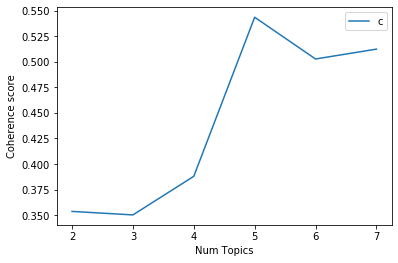

In [15]:
# Show graph

import matplotlib.pyplot as plt

limit=8; start=2; step=1;
x = range(start, limit)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [16]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3536
Num Topics = 3  has Coherence Value of 0.3502
Num Topics = 4  has Coherence Value of 0.388
Num Topics = 5  has Coherence Value of 0.5436
Num Topics = 6  has Coherence Value of 0.5027
Num Topics = 7  has Coherence Value of 0.5124


In [17]:
pyLDAvis.enable_notebook()
visual= gensimvis.prepare(lda_multicore_model, corpus, id2word)
#Save the output to the html file
pyLDAvis.save_html(visual, "base_5topic_viz.html")

C:\Users\genev\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


## Hyper-Parameter Tuning and Evaluation

In [16]:
# hyper-perameter tuning (alpha and beta)
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=42,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model_lda.get_coherence()
    perplex = lda_model.log_perplexity(corpus, total_docs=None)
    
    
    return coherence, perplex

In [17]:
# setup
import numpy as np

from gensim.models import CoherenceModel

model_list = []
coherence_values = []
perplexity_values = []
model_topics = []
alpha_result = []
beta_result = []

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

In [18]:
# Can take a few hours to run.
import datetime
import numpy as np
from gensim.models import CoherenceModel

print(datetime.datetime.now())

for a in alpha:
    for b in beta:
        for num_topics in range(2, 8):
            cv, pv = compute_coherence_values(corpus=corpus, dictionary=id2word,k=num_topics, a=a, b=b) 
            model_topics.append(num_topics)    
            coherence_values.append(cv)  
            perplexity_values.append(pv)
            alpha_result.append(a)
            beta_result.append(b)
            print("#Topics: " + str(num_topics) + ", CV Score: " + str(coherence_values[-1]) + ", PV Score: " + str(perplexity_values[-1]) + ", Alpha: " + str(alpha_result[-1]) + ", Beta: " + str(beta_result[-1]))
            
print(datetime.datetime.now())

2023-04-05 01:08:51.190178
#Topics: 2, CV Score: 0.3261254061364327, PV Score: -6.401565092071517, Alpha: 0.01, Beta: 0.01
#Topics: 3, CV Score: 0.41986292638697503, PV Score: -6.129120593517874, Alpha: 0.01, Beta: 0.01
#Topics: 4, CV Score: 0.4165450446379923, PV Score: -5.907244231205071, Alpha: 0.01, Beta: 0.01
#Topics: 5, CV Score: 0.5435572102468758, PV Score: -5.657276386944369, Alpha: 0.01, Beta: 0.01
#Topics: 6, CV Score: 0.516037365949147, PV Score: -5.510954498036066, Alpha: 0.01, Beta: 0.01
#Topics: 7, CV Score: 0.5123655930983843, PV Score: -5.458647301938402, Alpha: 0.01, Beta: 0.01
#Topics: 2, CV Score: 0.3261254061364327, PV Score: -6.663182035241686, Alpha: 0.01, Beta: 0.31
#Topics: 3, CV Score: 0.35018841605293183, PV Score: -6.48773088637582, Alpha: 0.01, Beta: 0.31
#Topics: 4, CV Score: 0.34331269338946674, PV Score: -6.371607857140804, Alpha: 0.01, Beta: 0.31
#Topics: 5, CV Score: 0.5182431105313009, PV Score: -6.2410819818437036, Alpha: 0.01, Beta: 0.31
#Topics: 6,

#Topics: 6, CV Score: 0.5049553910980755, PV Score: -6.7687392924992515, Alpha: 0.61, Beta: 0.9099999999999999
#Topics: 7, CV Score: 0.5055960142106721, PV Score: -6.725076718790164, Alpha: 0.61, Beta: 0.9099999999999999
#Topics: 2, CV Score: 0.3536084476549796, PV Score: -6.788542368364433, Alpha: 0.61, Beta: symmetric
#Topics: 3, CV Score: 0.35018841605293183, PV Score: -6.5116732783710605, Alpha: 0.61, Beta: symmetric
#Topics: 4, CV Score: 0.3879738755865584, PV Score: -6.285163714932678, Alpha: 0.61, Beta: symmetric
#Topics: 5, CV Score: 0.5435572102468758, PV Score: -6.030413518074326, Alpha: 0.61, Beta: symmetric
#Topics: 6, CV Score: 0.504864733763091, PV Score: -5.893254626117388, Alpha: 0.61, Beta: symmetric
#Topics: 7, CV Score: 0.5123655930983844, PV Score: -5.816938211704673, Alpha: 0.61, Beta: symmetric
#Topics: 2, CV Score: 0.3261254061364326, PV Score: -6.402858751303424, Alpha: 0.9099999999999999, Beta: 0.01
#Topics: 3, CV Score: 0.41986292638697503, PV Score: -6.132177

#Topics: 4, CV Score: 0.34331269338946674, PV Score: -6.372938886233844, Alpha: asymmetric, Beta: 0.31
#Topics: 5, CV Score: 0.5182431105313009, PV Score: -6.242342487846155, Alpha: asymmetric, Beta: 0.31
#Topics: 6, CV Score: 0.49939014981177876, PV Score: -6.119887578537144, Alpha: asymmetric, Beta: 0.31
#Topics: 7, CV Score: 0.5123655930983844, PV Score: -6.106362312009385, Alpha: asymmetric, Beta: 0.31
#Topics: 2, CV Score: 0.3536084476549796, PV Score: -6.85256268707287, Alpha: asymmetric, Beta: 0.61
#Topics: 3, CV Score: 0.35018841605293183, PV Score: -6.730323065645093, Alpha: asymmetric, Beta: 0.61
#Topics: 4, CV Score: 0.34331269338946674, PV Score: -6.646396450615411, Alpha: asymmetric, Beta: 0.61
#Topics: 5, CV Score: 0.5182431105313009, PV Score: -6.548446654802533, Alpha: asymmetric, Beta: 0.61
#Topics: 6, CV Score: 0.469415151943873, PV Score: -6.506452657864031, Alpha: asymmetric, Beta: 0.61
#Topics: 7, CV Score: 0.530771080503461, PV Score: -6.476754681620034, Alpha: as

In [33]:
hyperparameter_df = pd.DataFrame(
    {'num_topics': model_topics, 
     'coherence_score': coherence_values, 
     'perplexity_values': perplexity_values,
     'alpha': alpha_result, 
     'beta': beta_result})
hyperparameter_df

,num_topics,coherence_score,perplexity_values,alpha,beta
0,2,0.326125,-6.401565,0.01,0.01
1,3,0.419863,-6.129121,0.01,0.01
2,4,0.416545,-5.907244,0.01,0.01
3,5,0.543557,-5.657276,0.01,0.01
4,6,0.516037,-5.510954,0.01,0.01
...,...,...,...,...,...
175,3,0.350188,-6.510746,asymmetric,symmetric
176,4,0.387974,-6.283638,asymmetric,symmetric
177,5,0.543557,-6.029037,asymmetric,symmetric
178,6,0.516037,-5.879209,asymmetric,symmetric


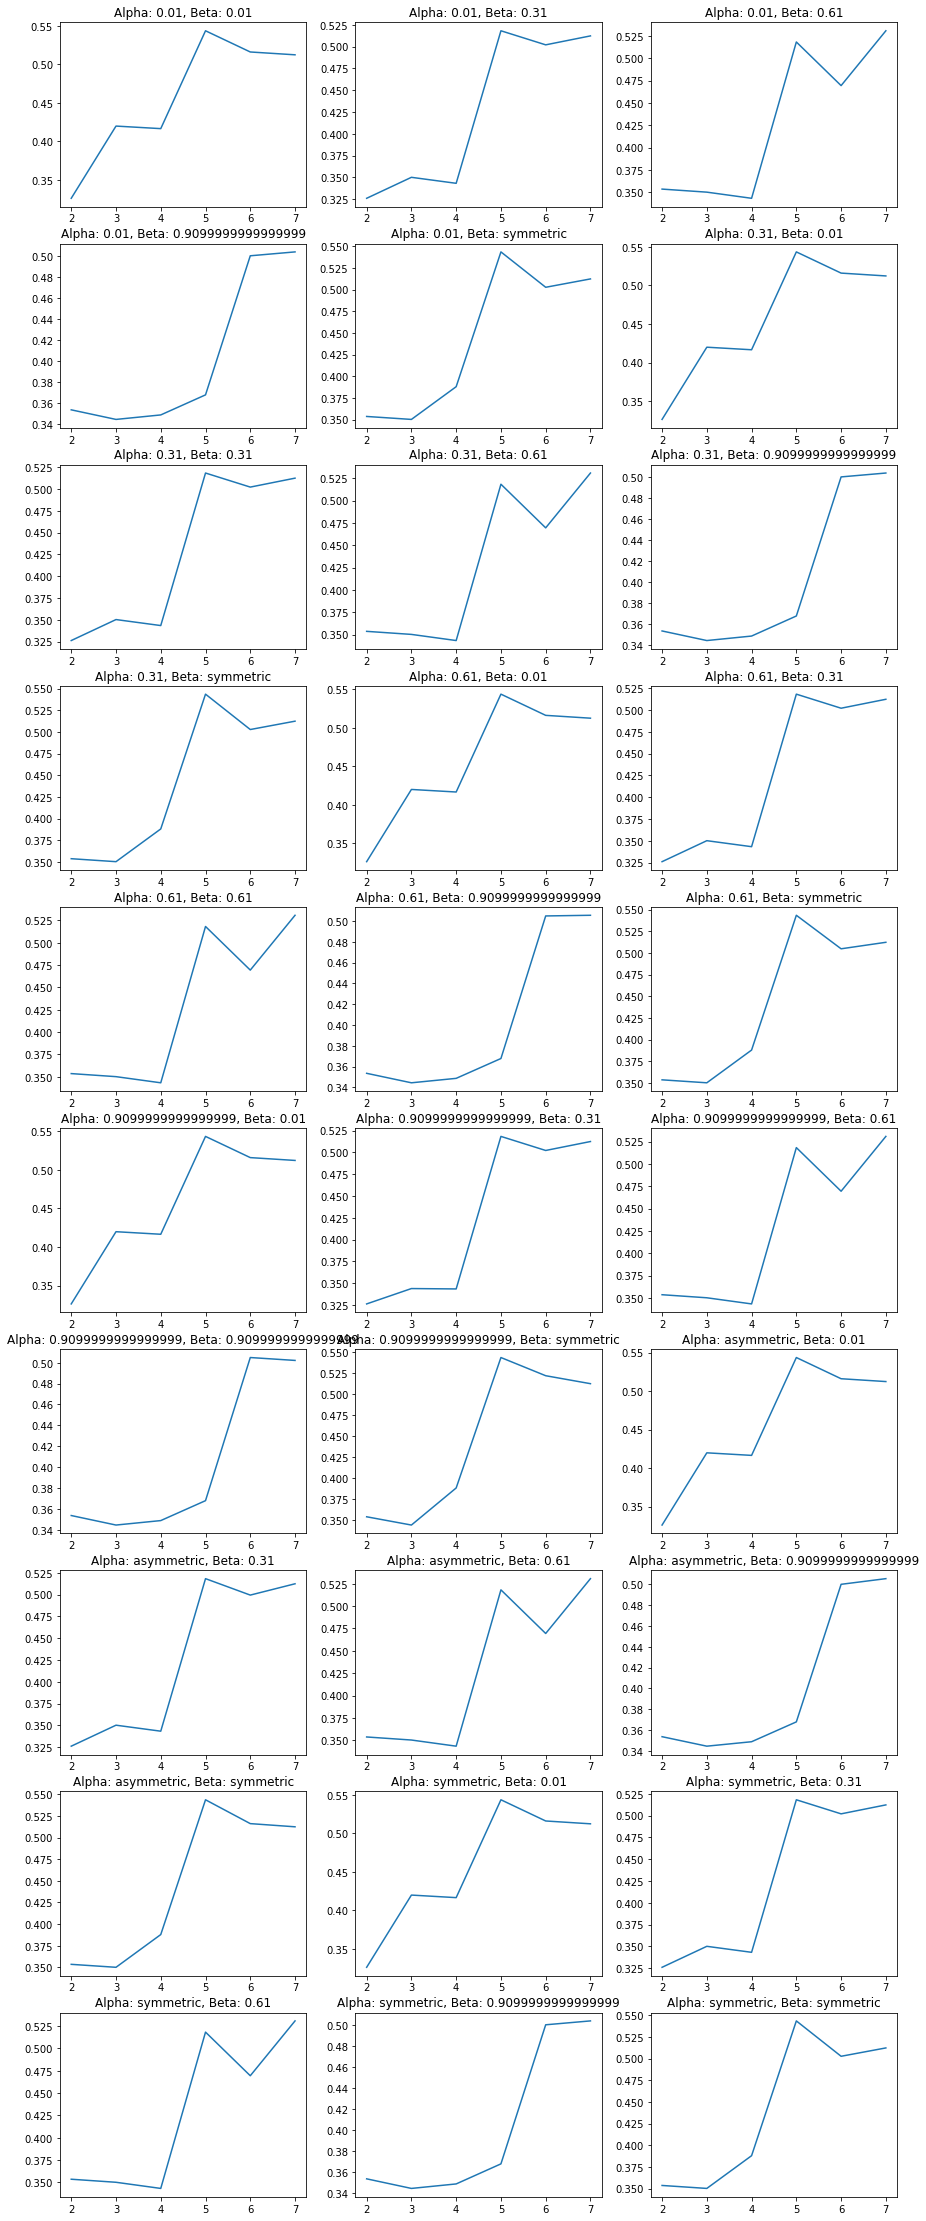

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(10,3, figsize = (15,40))
x=0
y=0

for model in hyperparameter_df.groupby(['alpha', 'beta']):
    ax[x,y].plot(model[1]['num_topics'], model[1]['coherence_score'])
    ax[x,y].title.set_text("Alpha: " + str(model[0][0]) + ", Beta: " + str(model[0][1]))
    y = y + 1
    if(y == 3):
        y = 0
        x = x + 1
# ax.set_xlabel('num_topics')
# ax.set_ylabel('coherence_score')

In [34]:
topic_5 = hyperparameter_df[hyperparameter_df["num_topics"] == 5]
topic_5.sort_values(by=['coherence_score', 'perplexity_values'], ascending=[False, False], inplace=True)
topic_5.head()

C:\Users\genev\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,num_topics,coherence_score,perplexity_values,alpha,beta
3,5,0.543557,-5.657276,0.01,0.01
123,5,0.543557,-5.658607,symmetric,0.01
153,5,0.543557,-5.658659,asymmetric,0.01
33,5,0.543557,-5.659383,0.31,0.01
63,5,0.543557,-5.661410,0.61,0.01


## Final Model

After hyperparameter tuning, we chose the model with the highest coherance_score and lowest perplexity_values at 5 topics and decided to use the model with the following parameters:
- num_topics = 5
- alpha = 0.01
- beta = 0.01

which has a coherence score of 0.54 and perplexity value of -6.03.

In [35]:
k = 5
a = 0.01
b = 0.01

final_lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                             id2word=id2word,
                                             num_topics=k,
                                             random_state=42,
                                             chunksize=100,
                                             passes=10,
                                             alpha=a,
                                             eta=b)

In [36]:
pyLDAvis.enable_notebook()
visual= gensimvis.prepare(final_lda_model, corpus, id2word)
#Save the output to the html file
pyLDAvis.save_html(visual, "Model/final_5topic_viz.html")

C:\Users\genev\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [182]:
visual

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.128209 -0.307555       1        1  28.889892
0      0.171603 -0.060917       2        1  22.362101
1     -0.152592  0.076945       3        1  19.520363
3     -0.347272 -0.006039       4        1  16.440123
2      0.200053  0.297565       5        1  12.787521, topic_info=             Term         Freq        Total Category  logprob  loglift
4099        dream  4835.000000  4835.000000  Default  30.0000  30.0000
318         child  2678.000000  2678.000000  Default  29.0000  29.0000
8824        woman  3254.000000  3254.000000  Default  28.0000  28.0000
503       country  1831.000000  1831.000000  Default  27.0000  27.0000
7592       sexual  2167.000000  2167.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
1350         love   414.543203  1302.585915   Topic5  -4.0860   0.9118
1619   phenomenon   277.098590  1007.780643   Topic5  -4.4889   0.7656
736     endeavour   169.298188   313.424757   Topic5  -4.9816   1.4408
7930     stimulus   163.643049   361.671625   Topic5  -5.0155   1.2637
1620  philosopher   163.135092   523.661904   Topic5  -5.0186   0.8904

[338 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
2487       5  0.998198     accuracy
2506       1  0.123752     activity
2506       2  0.875933     activity
2506       4  0.001934     activity
73         1  0.995775    affection
...      ...       ...          ...
2425       1  0.411979        young
2425       3  0.584482        young
2425       4  0.002029        young
16992      2  0.999166  zarathustra
16992      3  0.000825  zarathustra

[558 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 2, 4, 3])

In [37]:
# Save model
lda_sav=final_lda_model

lda_sav.save("Model/finalmodel_5Topics")

In [38]:
#Code to save the document topic probabilities (theta)
vec=lda_sav[corpus]
pd.DataFrame(vec).to_csv("Model/finaldoc_topic_mixture.csv")

In [39]:
# Write code here to save top 10 words for each topic (beta)
top_words_per_topic = []
for t in range(lda_sav.num_topics):
    top_words_per_topic.extend([(t, ) + x for x in lda_sav.show_topic(t, topn = 10)])

pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'P']).to_csv("Model/finaltop_words.csv")

In [40]:
id2word.save(("Model/finalmodel_Dictionary"))

### Secondary EDA

In [32]:
def format_topics_sentences(ldamodel, corpus, data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(data)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

#I choose model_list[2] where the number of topics is 6

df_topic_sents_keywords = format_topics_sentences(ldamodel=final_lda_model, corpus=corpus, data=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.8332,"country, price, labour, trade, quantity, land,...","[project_gutenberg, utilitarianism, john_stuar..."
1,1,4.0,0.9992,"dream, woman, child, sexual, girl, denote, lov...","[project_gutenberg, study, psychology, volume,..."
2,2,4.0,0.9955,"dream, woman, child, sexual, girl, denote, lov...","[project_gutenberg, youth, mary, scharlieb, ar..."
3,3,2.0,0.9938,"sensation, image, belief, consciousness, physi...","[project_gutenberg, psychology, achievement, w..."
4,4,4.0,0.9982,"dream, woman, child, sexual, girl, denote, lov...","[project_gutenberg, three, contribution, theor..."
5,5,1.0,0.9994,"government, city, plato, soul, citizen, justic...","[project_gutenberg, republic, plato, anyone_an..."
6,6,4.0,0.9987,"dream, woman, child, sexual, girl, denote, lov...","[project_gutenberg, dream, psychology, sigmund..."
7,7,4.0,0.9188,"dream, woman, child, sexual, girl, denote, lov...","[project_gutenberg, talk, teacher, psychology,..."
8,8,0.0,0.7330,"conception, zarathustra, thou, hath, pure, phe...","[project_gutenberg, apology, plato, anyone_any..."
9,9,2.0,0.9886,"sensation, image, belief, consciousness, physi...","[project_gutenberg, trained, memory, warren_hi..."


In [33]:
# Finding most representative document - Added
# find the documents a given topic has contributed to the most

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = [
   'Topic_Number', "Contribution_Perc", "Keywords", "Text"
]
sent_topics_sorteddf_mallet.head()

,Topic_Number,Contribution_Perc,Keywords,Text
0,0.0,0.9997,"conception, zarathustra, thou, hath, pure, phe...","[project_gutenberg, critique, pure, reason, im..."
1,1.0,0.9994,"government, city, plato, soul, citizen, justic...","[project_gutenberg, republic, plato, anyone_an..."
2,2.0,0.9993,"sensation, image, belief, consciousness, physi...","[project_gutenberg, ethic, benedict, anyone_an..."
3,3.0,0.9999,"country, price, labour, trade, quantity, land,...","[project_gutenberg, wealth, nation, adam, smit..."
4,4.0,0.9996,"dream, woman, child, sexual, girl, denote, lov...","[project_gutenberg, dream, interpret, miller, ..."


In [34]:
# Volume and distribution of Topics; how widely topic is discussed in documents

# Calc no. of docs for every topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
# Calc % of docs for every topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]
df_dominant_topics = pd.concat(
   [topic_num_keywords, topic_counts, topic_contribution], axis=1
)
df_dominant_topics.columns = [
   'Dominant-Topic', 'Topic-Keywords', 'Num_Documents', '%_Documents'
]
df_dominant_topics.head()

,Dominant-Topic,Topic-Keywords,Num_Documents,%_Documents
0.0,3.0,"country, price, labour, trade, quantity, land,...",9.0,0.1957
1.0,4.0,"dream, woman, child, sexual, girl, denote, lov...",9.0,0.1957
2.0,4.0,"dream, woman, child, sexual, girl, denote, lov...",8.0,0.1739
3.0,2.0,"sensation, image, belief, consciousness, physi...",4.0,0.0870
4.0,4.0,"dream, woman, child, sexual, girl, denote, lov...",16.0,0.3478
